# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import cm
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events.root'
fileName = '../build/event.root'
histDir = '/photoSensor_hits_histograms'
print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName_photoSensor = 'photoSensor_hits;1'
treeName_lens        = 'lens_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'                        ] = get_photosensor_hits_photosensor_ID              (fileName, treeName_photoSensor)
df_hits['sensor_direction'                   ] = get_photosensor_hits_photosensor_direction       (fileName, treeName_photoSensor)
df_hits['sensor_position'                    ] = get_photosensor_hits_photosensor_position        (fileName, treeName_photoSensor)
df_hits['relativePosition'                   ] = get_photosensor_hits_position_relative           (fileName, treeName_photoSensor)
df_hits['relativePosition_binned'            ] = get_photosensor_hits_position_relative_binned    (fileName, treeName_photoSensor, histDir)
df_hits['relativePosition_nBin'              ] = get_photosensor_hits_position_relative_nBin      (fileName, treeName_photoSensor, histDir)
df_hits['initialPosition'                    ] = get_photosensor_hits_position_initial            (fileName, treeName_photoSensor)
df_hits['time'                               ] = get_photosensor_hits_time                        (fileName, treeName_photoSensor)

df_hits['direction_relative'                 ] = get_photosensor_hits_direction_relative     (fileName, treeName_photoSensor)
df_hits['direction_relative_lens_0'          ] = get_photosensor_hits_direction_relative_lens(fileName, treeName_photoSensor, 0)
df_hits['position_relative_lens_0'           ] = get_photosensor_hits_position_relative_lens (fileName, treeName_photoSensor, 0)
df_hits['direction_relative_lens_1'          ] = get_photosensor_hits_direction_relative_lens(fileName, treeName_photoSensor, 1)
df_hits['position_relative_lens_1'           ] = get_photosensor_hits_position_relative_lens (fileName, treeName_photoSensor, 1)

df_hits = df_hits[df_hits['direction_relative_lens_0'] != (0, 0, 0)]
df_hits = df_hits[df_hits['direction_relative_lens_1'] != (0, 0, 0)]
df_hits = df_hits[df_hits['position_relative_lens_0' ] != (0, 0, 0)]
df_hits = df_hits[df_hits['position_relative_lens_1' ] != (0, 0, 0)]

df_hits['direction_relative_lens_0_theta'    ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))
df_hits['direction_relative_lens_0_phi'      ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_lens_0_phi'       ] = df_hits['position_relative_lens_0' ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['direction_relative_lens_1_theta'    ] = df_hits['direction_relative_lens_1'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))
df_hits['direction_relative_lens_1_phi'      ] = df_hits['direction_relative_lens_1'].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_lens_1_phi'       ] = df_hits['position_relative_lens_1' ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['direction_relative_phi'             ] = df_hits['direction_relative'       ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_phi'              ] = df_hits['relativePosition'         ].apply(lambda x: np.arctan2(x[1], x[0]))

In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)

# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Reconstruct Hit Angle

In [8]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)
df_hits = make_r(df_hits)
df_hits = filter_r(df_hits, Y_LIM)
df_hits = make_theta(df_hits, rToTheta)
df_hits = make_phi(df_hits)

# Plot Reconstruction Performance

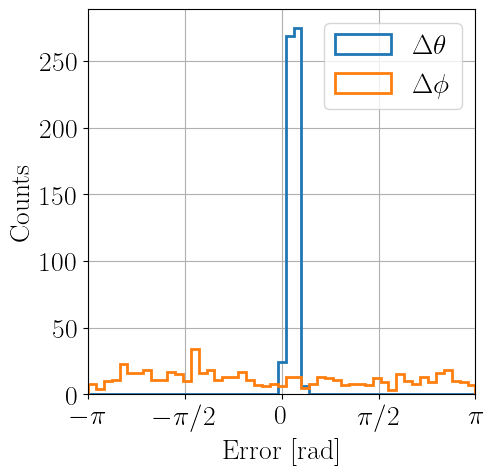

In [9]:
nBins = 50
lw = 2

bins = np.linspace(-np.pi, np.pi, nBins)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(df_hits['direction_relative_lens_0_theta'], bins=bins, histtype='step', label=r'$\Delta\theta$', lw=lw)
ax.hist(df_hits['direction_relative_lens_0_phi'  ], bins=bins, histtype='step', label=r'$\Delta\phi$'  , lw=lw)
ax.legend()
ax.set_xlabel('Error [rad]')
ax.set_ylabel('Counts')
ax.set_xlim(-np.pi, np.pi)
ax.set_xticks(np.linspace(-np.pi, np.pi, 5))
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax.grid()
plt.show()

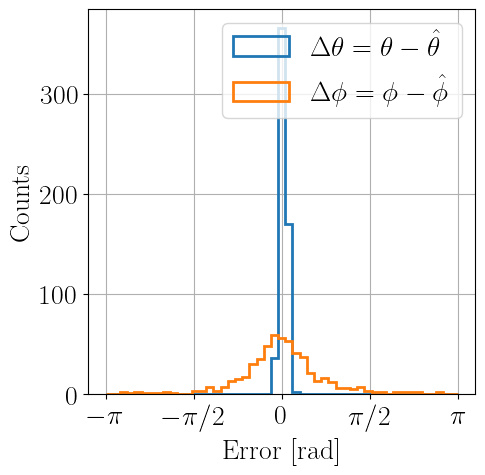

In [10]:
nBins = 50
lw = 2

error_theta = df_hits['direction_relative_lens_0_theta'] - df_hits['theta'                 ]
error_phi   = df_hits['direction_relative_lens_0_phi'  ] - df_hits['position_relative_phi' ]

bins = np.linspace(-np.pi, np.pi, nBins)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(error_theta, bins=bins, histtype='step', lw=lw, label=r'$\Delta\theta=\theta-\hat{\theta}$')
ax.hist(error_phi  , bins=bins, histtype='step', lw=lw, label=r'$\Delta\phi=\phi-\hat{\phi}$'    )
ax.legend()
ax.set_xlabel('Error [rad]')
ax.set_ylabel('Counts')
# ax.set_yscale('log')
# ax.set_xlim(-np.pi, np.pi)
ax.set_xticks(np.linspace(-np.pi, np.pi, 5))
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax.grid()
plt.show()

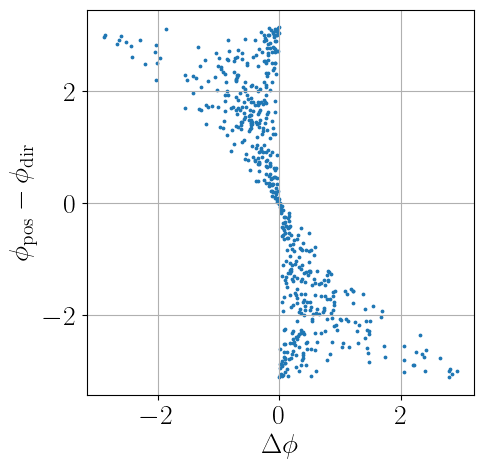

In [11]:
error_phi  = df_hits['direction_relative_lens_0_phi'] - df_hits['phi']
posDir_phi = df_hits['position_relative_lens_0_phi' ] - df_hits['direction_relative_lens_0_phi']

def normailzePhi(phi):
    return (phi + np.pi) % (2 * np.pi) - np.pi

error_phi  = normailzePhi(error_phi)
posDir_phi = normailzePhi(posDir_phi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(error_phi, posDir_phi, s=3)
ax.set_xlabel(r'$\Delta\phi$')
ax.set_ylabel(r'$\phi_{\text{pos}} - \phi_{\text{dir}}$')
# ax.set_xlim(-np.pi, np.pi)
ax.grid()
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_1485/2079197602.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


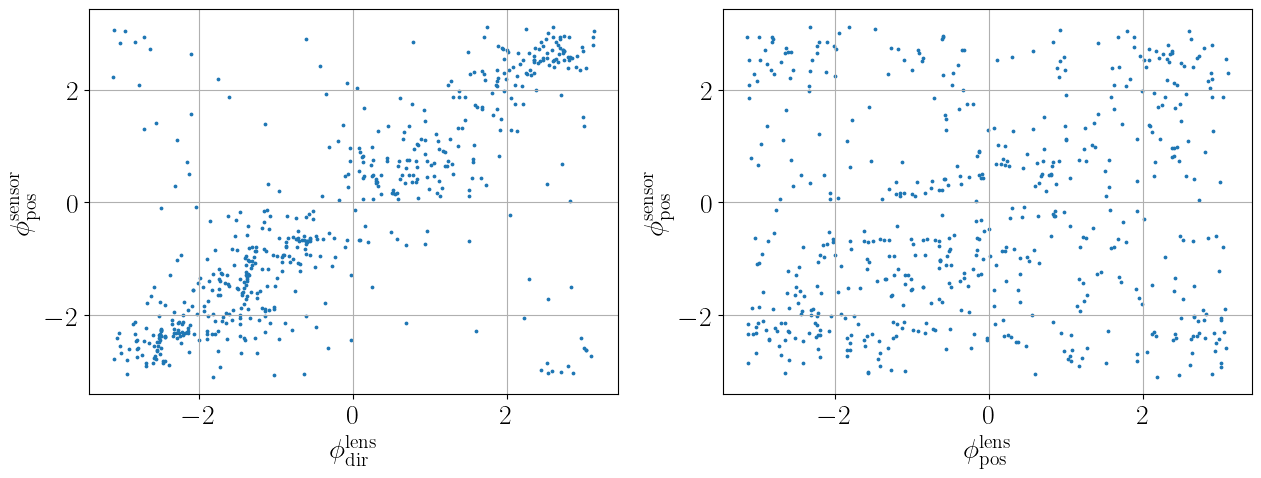

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(df_hits['direction_relative_lens_0_phi'], df_hits['position_relative_phi'], s=3)
ax[0].set_xlabel(r'$\phi_{\text{dir}}^{\text{lens}}$')
ax[0].set_ylabel(r'$\phi_{\text{pos}}^{\text{sensor}}$')
ax[0].grid()

ax[1].scatter(df_hits['position_relative_lens_0_phi'], df_hits['position_relative_phi'], s=3)
ax[1].set_xlabel(r'$\phi_{\text{pos}}^{\text{lens}}$')
ax[1].set_ylabel(r'$\phi_{\text{pos}}^{\text{sensor}}$')
ax[1].grid()

fig.show()

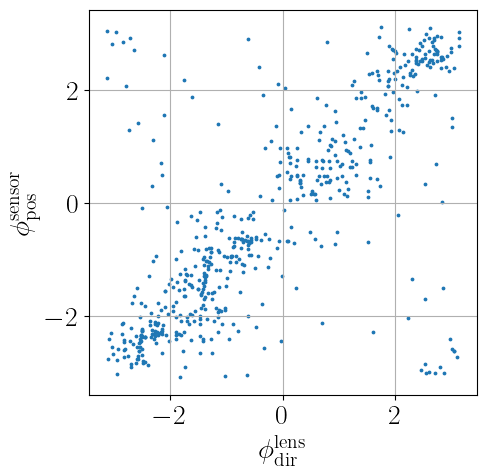

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_hits['direction_relative_lens_0_phi'], df_hits['position_relative_phi'], s=3)
ax.set_xlabel(r'$\phi_{\text{dir}}^{\text{lens}}$')
ax.set_ylabel(r'$\phi_{\text{pos}}^{\text{sensor}}$')
ax.grid()
plt.show()

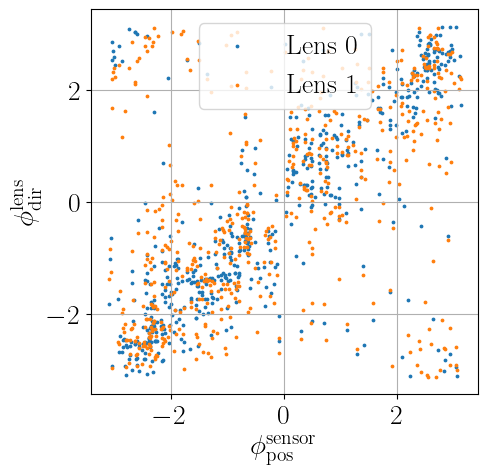

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_hits['position_relative_phi'], df_hits['direction_relative_lens_0_phi'], s=3, label='Lens 0')
ax.scatter(df_hits['position_relative_phi'], df_hits['direction_relative_lens_1_phi'], s=3, label='Lens 1')
ax.set_xlabel(r'$\phi_{\text{pos}}^{\text{sensor}}$')
ax.set_ylabel(r'$\phi_{\text{dir}}^{\text{lens}}$')
ax.legend()
ax.grid()
plt.show()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_1485/2523850383.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


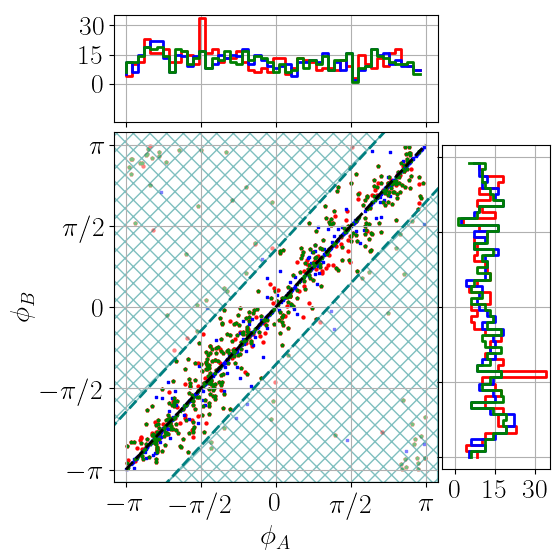

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1]})

sigma = np.pi/4
Delta = 0.25
xMax = np.pi + Delta
xMin = -np.pi - Delta
yMax = np.pi + Delta
yMin = -np.pi - Delta

nBins = 50

color = 'teal'
lw = 2

sigma_prime = sigma/np.sqrt(2)

ax[0,1].clear()
ax[0,1].set_axis_off()

ax[0,1].scatter([],[], s=40, marker='o', color='r', label=r'$\phi_A=\phi\in\gamma_i$, \hspace{3mm} $\phi_B=\phi\in\gamma_{01}$')
ax[0,1].scatter([],[], s=40, marker='s', color='b', label=r'$\phi_A=\phi\in\gamma_{01}$, \hspace{0mm} $\phi_B=\phi\in\gamma_t$')
ax[0,1].scatter([],[], s=40, marker='*', color='g', label=r'$\phi_A=\phi\in\gamma_i$, \hspace{3mm} $\phi_B=\phi\in\gamma_t$'   )

ax[1,0].scatter(df_hits['direction_relative_lens_0_phi'], df_hits['direction_relative_lens_1_phi'], s=4.5, marker='o', color='r', alpha=1)
ax[1,0].scatter(df_hits['direction_relative_lens_1_phi'], df_hits['direction_relative_phi'       ], s=4.5, marker='s', color='b', alpha=1)
ax[1,0].scatter(df_hits['direction_relative_lens_0_phi'], df_hits['direction_relative_phi'       ], s=4.5, marker='*', color='g', alpha=1)

ax[1,0].plot([-np.pi, np.pi], [-np.pi, np.pi], 'k--', lw=lw)
ax[1,0].plot([-np.pi-sigma_prime, np.pi-sigma_prime], [-np.pi+sigma_prime, np.pi+sigma_prime], color=color, lw=lw, linestyle='--')
ax[1,0].plot([-np.pi+sigma_prime, np.pi+sigma_prime], [-np.pi-sigma_prime, np.pi-sigma_prime], color=color, lw=lw, linestyle='--')
ax[1,0].fill_between([xMin, xMax], [yMax, yMax], [xMin+2*sigma_prime, xMax+2*sigma_prime], facecolor='white', alpha=0.5, hatch=r'xx', edgecolor=color)
ax[1,0].fill_between([xMin, xMax], [yMin, yMin], [xMin-2*sigma_prime, xMax-2*sigma_prime], facecolor='white', alpha=0.5, hatch=r'xx', edgecolor=color)

hist_1_i, bins_1_i = np.histogram(df_hits['direction_relative_lens_0_phi'], bins=np.linspace(-np.pi, np.pi, nBins))
hist_1_01, bins_1_01 = np.histogram(df_hits['direction_relative_lens_1_phi'], bins=np.linspace(-np.pi, np.pi, nBins))
hist_1_t, bins_1_t = np.histogram(df_hits['direction_relative_phi'], bins=np.linspace(-np.pi, np.pi, nBins))

ax[0,0].plot(bins_1_i[:-1], hist_1_i, color='r', lw=lw, ls='-', drawstyle='steps-pre')
ax[0,0].plot(bins_1_01[:-1], hist_1_01, color='b', lw=lw, ls='-', drawstyle='steps-pre')
ax[0,0].plot(bins_1_t[:-1], hist_1_t, color='g', lw=lw, ls='-', drawstyle='steps-pre')

hist_2_i, bins_2_i = np.histogram(df_hits['direction_relative_lens_0_phi'], bins=np.linspace(-np.pi, np.pi, nBins))
hist_2_01, bins_2_01 = np.histogram(df_hits['direction_relative_lens_1_phi'], bins=np.linspace(-np.pi, np.pi, nBins))
hist_2_t, bins_2_t = np.histogram(df_hits['direction_relative_phi'], bins=np.linspace(-np.pi, np.pi, nBins))

ax[1,1].plot(hist_2_i, bins_2_i[:-1], color='r', lw=lw, ls='-', drawstyle='steps-pre')
ax[1,1].plot(hist_2_01, bins_2_01[:-1], color='b', lw=lw, ls='-', drawstyle='steps-pre')
ax[1,1].plot(hist_2_t, bins_2_t[:-1], color='g', lw=lw, ls='-', drawstyle='steps-pre')

ax[1,0].set_xlabel(r'$\phi_A$')
ax[1,0].set_ylabel(r'$\phi_B$')
ax[1,0].set_xlim(xMin, xMax)
ax[1,0].set_ylim(yMin, yMax)
ax[1,0].set_xticks(np.linspace(-np.pi, np.pi, 5))
ax[1,0].set_yticks(np.linspace(-np.pi, np.pi, 5))
ax[1,0].set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[1,0].set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
# ax[1,0].set_aspect('equal')

ax[0,0].set_xlabel(r'')
ax[0,0].set_ylabel(r'')
ax[0,0].set_xlim(xMin, xMax)
ax[0,0].set_ylim(ymin=-20)
ax[0,0].set_xticks(np.linspace(-np.pi, np.pi, 5))
ax[0,0].set_yticks(np.linspace(0, 30, 3))
# ax[0,0].set_yticks(np.linspace(-2, 2, 5))
ax[0,0].set_xticklabels(['']*5)
# ax[0,0].set_yticklabels(['']*5)
ax[0,0].grid()
ax[0,0].set_aspect((xMax-xMin)/(ax[0,0].get_ylim()[1]-ax[0,0].get_ylim()[0])/3)

ax[1,1].set_xlabel(r'')
ax[1,1].set_ylabel(r'')
ax[1,1].set_xlim(xmin=-5)
ax[1,1].set_ylim(yMin, yMax)
# ax[1,1].set_xticks(np.linspace(-2, 2, 5))
ax[1,1].set_xticks(np.linspace(0, 30, 3))
ax[1,1].set_yticks(np.linspace(-np.pi, np.pi, 5))
# ax[1,1].set_xticklabels(['']*5)
ax[1,1].set_yticklabels(['']*5)
ax[1,1].grid()
ax[1,1].set_aspect((ax[1,1].get_xlim()[1]-ax[1,1].get_xlim()[0])/(yMax-yMin)*3)

# ax[0,1].legend(loc='lower left', bbox_to_anchor=(0, 0))
ax[1,0].grid()

fig.tight_layout(h_pad=0, w_pad=0)

fig.savefig('../figures/dirPhi_translation.pdf', bbox_inches='tight')
fig.show()